<a href="https://colab.research.google.com/github/omarhashem80/Siamese_Network/blob/main/Deep_Learning_with_PyTorch_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 30.67 MiB/s, done.


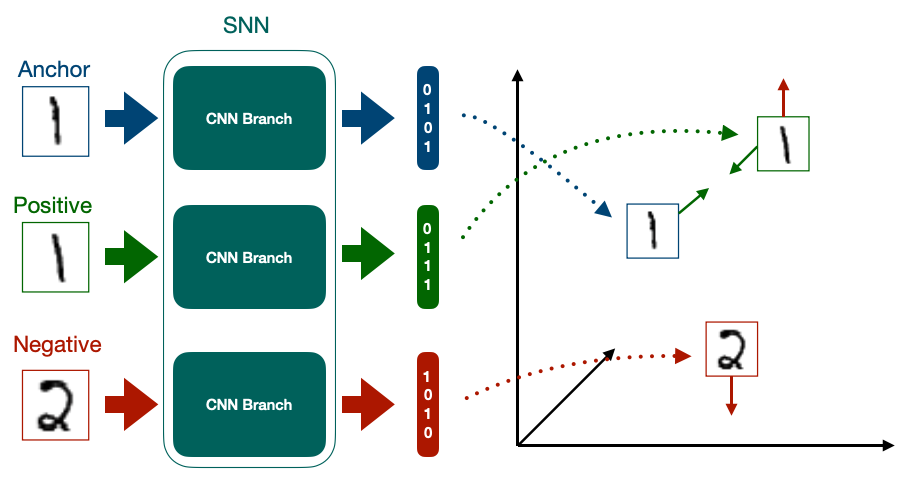

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [10]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [11]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [16]:
row = df.iloc[1]

A_img = io.imread(DATA_DIR + row['Anchor'])
P_img = io.imread(DATA_DIR + row['Positive'])
N_img = io.imread(DATA_DIR + row['Negative'])

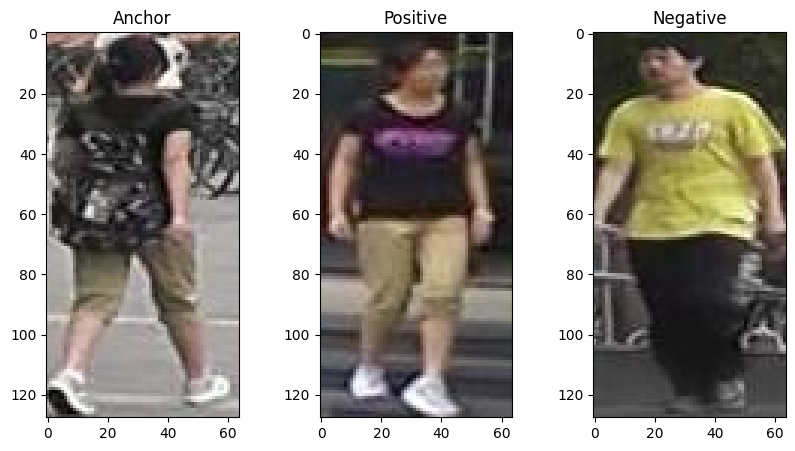

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10, 5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [18]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Create APN Dataset

In [19]:
class APN_Dataset(Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        A_img = io.imread(DATA_DIR + row['Anchor'])
        P_img = io.imread(DATA_DIR + row['Positive'])
        N_img = io.imread(DATA_DIR + row['Negative'])

        A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
        P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
        N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

        return A_img, P_img, N_img


In [20]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Length of trainset : {len(trainset)}")
print(f"Length of validset : {len(validset)}")

Length of trainset : 3200
Length of validset : 800


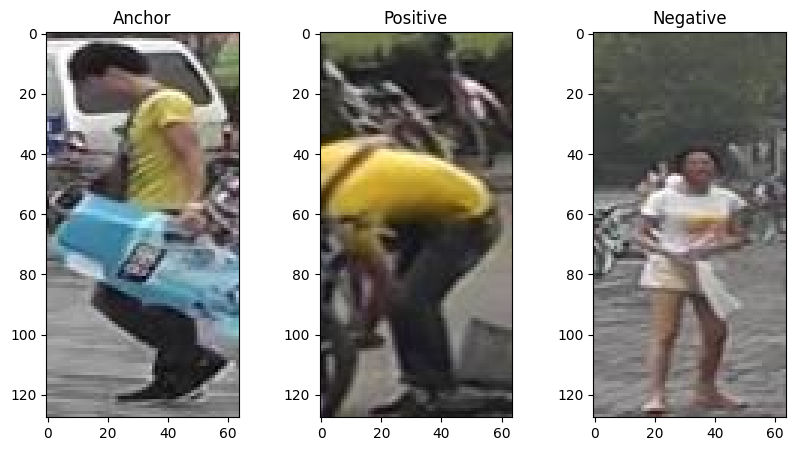

In [21]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [22]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [23]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [24]:
for A, P, N in trainloader:
    break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [25]:
class APN_Model(nn.Module):

    def __init__(self, emb_size = 512):
        super(APN_Model, self).__init__()
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
        self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)

    def forward(self, images):

        embeddings = self.efficientnet(images)

        return embeddings

In [26]:
model = APN_Model()
model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw):

# Create Train and Eval function

In [27]:
def train_fn(model, dataloader, optimizer, criterion):

    model.train()
    total_loss = 0.0

    for A, P, N in tqdm(dataloader):

        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)



In [28]:
def eval_fn(model, dataloader, criterion):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for A, P, N in tqdm(dataloader):

            A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            loss = criterion(A_embs, P_embs, N_embs)

            total_loss += loss.item()

    return total_loss / len(dataloader)



In [29]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [30]:
best_valid_loss = np.inf

for epoch in range(EPOCHS):

    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print('SAVED_WEIGHTS_SUCCESS')

    print(f"Epoch : {epoch+1} train Loss : {train_loss} valid Loss : {valid_loss}")

100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 1 train Loss : 0.5412268385291099 valid Loss : 0.44229496121406553


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 2 train Loss : 0.28116633102297783 valid Loss : 0.36708983600139616


100%|██████████| 25/25 [00:03<00:00,  6.97it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 3 train Loss : 0.18279080495238303 valid Loss : 0.2185916817188263


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Epoch : 4 train Loss : 0.11435369491577148 valid Loss : 0.24361051499843597


100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


Epoch : 5 train Loss : 0.10587451025843621 valid Loss : 0.24433747589588165


100%|██████████| 25/25 [00:03<00:00,  7.63it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 6 train Loss : 0.08515204265713691 valid Loss : 0.20811111927032472


100%|██████████| 25/25 [00:03<00:00,  8.07it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 7 train Loss : 0.06037545204162598 valid Loss : 0.19084892868995668


100%|██████████| 25/25 [00:03<00:00,  8.26it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 8 train Loss : 0.06003729224205017 valid Loss : 0.16118748247623443


100%|██████████| 25/25 [00:03<00:00,  8.26it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 9 train Loss : 0.03495647005736828 valid Loss : 0.15502665042877198


100%|██████████| 25/25 [00:03<00:00,  8.26it/s]


Epoch : 10 train Loss : 0.053891219794750214 valid Loss : 0.16609463930130006


100%|██████████| 25/25 [00:03<00:00,  8.16it/s]


Epoch : 11 train Loss : 0.051404322758316995 valid Loss : 0.23043012440204622


100%|██████████| 25/25 [00:03<00:00,  7.64it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 12 train Loss : 0.03619662567973137 valid Loss : 0.1340044593811035


100%|██████████| 25/25 [00:03<00:00,  8.17it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 13 train Loss : 0.03146774865686894 valid Loss : 0.11677449077367782


100%|██████████| 25/25 [00:03<00:00,  8.22it/s]


Epoch : 14 train Loss : 0.032632687240839 valid Loss : 0.17055724918842316


100%|██████████| 25/25 [00:03<00:00,  8.17it/s]

Epoch : 15 train Loss : 0.026728382781147957 valid Loss : 0.1508461207151413


# Get Anchor Embeddings

In [38]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encoding = []

    model.eval()

    with torch.no_grad():
        for img_name in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + img_name)
            A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
            A = A.to(DEVICE)
            A_enc = model(A.unsqueeze(0)) # (c, h, w) -> (bs, c, h, w)
            A_emb = A_enc.squeeze().cpu().detach().numpy()
            encoding.append(A_emb)

        encoding = np.array(encoding)
        encoding = pd.DataFrame(encoding)
        df_enc = pd.concat([pd.Series(anc_img_names), encoding], axis = 1)

    return df_enc

In [39]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

<ipython-input-39-fb78bba7c639>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
100%|██████████| 4000/4000 [00:45<00:00, 

In [40]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.482585,0.357305,0.672459,1.039094,-0.949635,0.591330,-0.595681,-0.435799,-0.026521,...,-0.058764,-1.108766,0.318353,0.187730,1.223535,0.700340,0.423005,-0.401911,-0.440347,0.405970
1,1420_c3s3_061978_03.jpg,0.581770,0.532365,0.180336,1.098312,-0.974366,0.721669,-0.508201,0.214644,-0.181645,...,-0.491471,-0.444254,-0.065463,0.081632,1.015437,0.133432,-0.164689,-0.485696,-0.351759,0.260471
2,1420_c5s3_062565_05.jpg,0.520300,0.343762,0.572795,1.003558,-0.864248,0.626875,-0.420169,-0.193724,-0.078978,...,-0.178283,-0.947985,0.323723,0.250689,0.997661,0.617002,0.231457,-0.484439,-0.483204,0.354373
3,1420_c6s3_085592_04.jpg,0.594028,0.434152,0.438134,0.926794,-1.161252,0.415736,-0.666347,-0.321607,0.204416,...,-0.233024,-0.704532,0.256740,0.003070,0.816283,0.786308,0.071990,-0.511702,-0.335331,0.601478
4,0663_c5s3_085987_03.jpg,-0.468992,-0.052529,-0.264469,-0.221637,-0.326204,-0.659718,-0.535375,-0.641891,0.437141,...,0.506096,-0.774003,0.118813,-0.596615,0.225188,-0.042286,-0.090592,0.165640,0.412904,0.896531


# Inference

In [41]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist

In [44]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
img = img.to(DEVICE)

model.eval()

with torch.no_grad():
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

In [53]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [54]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, anc_enc_arr[i: i+1, :])
    distance = np.append(distance, dist)

In [55]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.11/dist-packages/networkx/drawing/layout.py:728: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


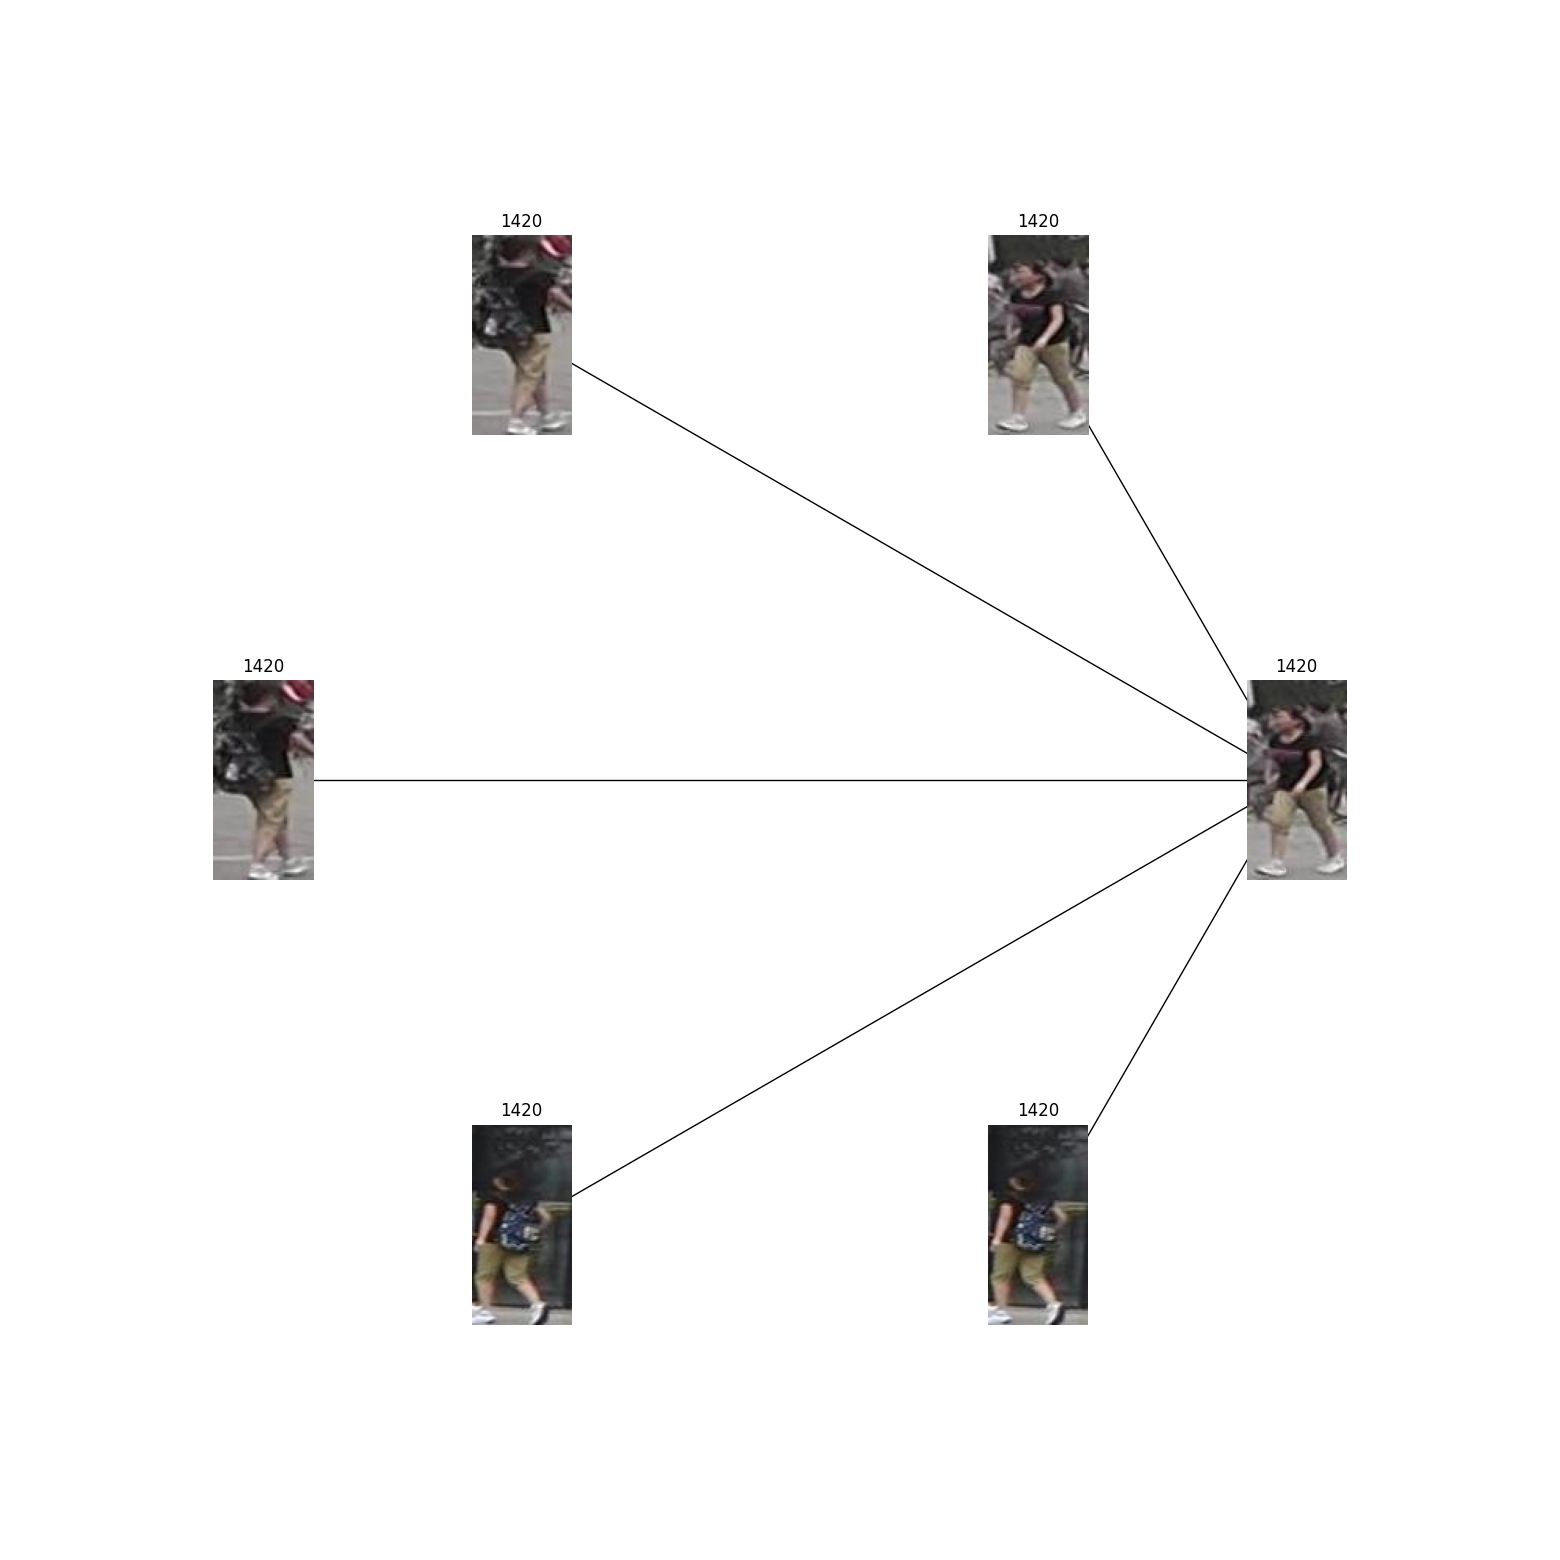

In [56]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);